## Creation of a relevant SAR dataset

The goal of this notebook is to create a relevant SAR dataset with appropriate extra-parameters using Cyclobs API requests as well as xarray.Dataset structure.


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS = {
    'sar_dir': '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'ibt_pth': '/home/arthur/data/ibtracs/IBTrACS.ALL.v04r00.nc',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/',
    'sav_nme': 'ds_glob.nc',
}


PARAMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
    'vars_of_interest': ['wind_speed', 'lon', 'lat', 'track_vmax', 'distance_to_coast', 'cyclone_speed', 'cyclone_speed_std', 'rotation_angle', 'rotation_angle_std', 
                         'vmax', 'rmax', 'tco_radii_ms_all', 'tco_radii_ms_FR', 'tco_radii_ms_FL', 'tco_radii_ms_RR', 'tco_radii_ms_RL', 'cyclone_category'],
    'Rmax_1D_bound':    150,

    'save_data': True,
    'save_fit_figs': False,
    'save_figs': False, # important because it is called by function f.compute_SAR_1D_radii(ds, PARAMS)
}

# Open IBTrACS
ds_ibt_raw = xr.open_dataset(PATHS['ibt_pth'])
ds_ibt     = ds_ibt_raw[PARAMS['ibt_vars2keep']]
ds_ibt[PARAMS['ibt_info2keep']] = ds_ibt_raw[PARAMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings

start_date = np.datetime64('2009-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, None))

In [3]:
### OPEN DATA
sar_data_all = glob.glob(PATHS['sar_dir'] + "*.nc")
print("Total number of files:", len(sar_data_all))

Total number of files: 335


In [4]:
### CONVERSIONS
# Convert to m/s and km units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1.852

In [5]:
# Intensification and growing rates in IBTrACS
ds_ibt['vmx_dot'] = ds_ibt.usa_wind.differentiate(coord='date_time', datetime_unit='h') / 3               # m/s/hr
ds_ibt['vmx_dot_smth'] = ds_ibt.usa_wind.rolling(date_time=4).mean().differentiate(coord='date_time') / 3 # m/s/hr
ds_ibt['rmx_dot'] = ds_ibt.usa_rmw.differentiate(coord='date_time', datetime_unit='h') / 3               # km/hr
ds_ibt['rmx_dot_smth'] = ds_ibt.usa_rmw.rolling(date_time=4).mean().differentiate(coord='date_time') / 3 # km/hr
ds_ibt['r34_dot'] = ds_ibt.usa_r34.mean(dim='quadrant', skipna=True).differentiate(coord='date_time') / 3 # km/hr

In [6]:
### FUNCTIONS

def get_cat_as_nb(ds):
    """For a given ds, returns the category as a number (0 for storm or dep, 1, ..., 5 for other categories)"""
    cat = np.array(ds['cyclone_category'])
    if cat == 'storm' or cat == 'dep':
        cat = 0
    else: # then it's 'cat-0', 1, ..., or 5
        cat = int(str(cat)[-1])
    return cat

def compute_SAR_1D_radii(ds, PARAMS):
    '''Given a xarray.Dataset ds, computes its radii in 1D.
    Output: Rmax_1D, Vmax_1D, and a dict containing R34_1D, R50_1D, R64_1D.'''
    # Compute radial wind speed profile
    spdm = np.array(ds.isel(time=0)['wind_speed'].mean(dim='theta', skipna=True)) # convert to np.array() to use scipy.signal.argrelextrema
    stdm = np.array(ds.isel(time=0)['wind_speed'].std(dim='theta',  skipna=True))
    # Compute Rmax and Vmax in 1D
    Rmax_1D, Vmax_1D = np.nanargmax(spdm[:PARAMS['Rmax_1D_bound'] + 1]), np.nanmax(spdm[:PARAMS['Rmax_1D_bound'] + 1])
    Vmax_std         = stdm[Rmax_1D]
    Vmin_1D          = np.nanmin(spdm[:Rmax_1D])
    # Set to Nan if Rmax_1D = 150 km
    if Rmax_1D >= PARAMS['Rmax_1D_bound']:
        Rmax_1D = np.nan
        Vmax_1D = np.nan
    # Prepare dict for R17, R26 and R33
    radii_in_ms        = [17.4911, 25.7222, 32.9244]
    radii_keys         = [np.int(np.round(e)) for e in radii_in_ms]
    RADII_1D           = dict.fromkeys(radii_keys, 0.)
    RADII_STD          = dict.fromkeys(radii_keys, 0.)
    # Update dict
    for x, speed_value in enumerate(radii_in_ms):
        if Vmin_1D < speed_value and Vmax_1D > speed_value:
            diff           = np.abs(spdm[Rmax_1D:] - speed_value)
            global_minimum = np.nanargmin(diff) + Rmax_1D   # Old version: doesn't take 2ndary eyewall
            local_minima   = argrelextrema(diff, np.less, order=20)[0] + Rmax_1D
            local_diff     = np.abs(spdm[local_minima] - speed_value)
            if x == 0: # R34
                local_minima   = local_minima[local_diff < 0.3] # filter out local minima that don't correspond to speed_value
            else:      # R50 and R64
                local_minima   = local_minima[local_diff < 2.]  # Allow for more flexibility
            # if not empty array, take local minima
            if np.size(local_minima) != 0:
                RADII_1D[radii_keys[x]] = local_minima[0] # Take the first local minimum
                RADII_STD[radii_keys[x]]= stdm[local_minima[0]]
            else:
                RADII_1D[radii_keys[x]] = np.nan          # Else it means that real minimum is too noisy or belongs to the end of spdm ==> nan
                RADII_STD[radii_keys[x]]= np.nan
        else:
            RADII_1D[radii_keys[x]] = np.nan
            RADII_STD[radii_keys[x]]= np.nan
            
    if PARAMS['save_figs']:
        # Plot
        fig, _ = plt.subplots()
        plt.plot(spdm)
        plt.scatter(Rmax_1D, Vmax_1D, c='r', s=100, label='Rmax, R34 (Own)')
        plt.scatter(RADII_1D[17], radii_in_ms[0], c='r', s=100)
        plt.scatter(ds['tco_radii_ms_all'][1] / 1000, ds['tco_radii_ms_all'][0], c='k', s=100, alpha=0.5, label='Rmax, R34 (Cyclobs)')
        plt.scatter(ds['tco_radii_ms_all'][4] / 1000, radii_in_ms[0], c='k', s=100, alpha=0.5)
        plt.xlabel('r (km)')
        plt.ylabel('Wind speed (m/s)')
        plt.grid();plt.legend()
        
        # Save
        filename = os.path.splitext(ds.attrs['Source satellite file'])[0] + '_SAR1D'
        plt.savefig(PARAMS['save_dir_figs'] + filename)
        
    return Rmax_1D, Vmax_1D, RADII_1D, Vmax_std, RADII_STD, spdm

def rankine(r, vmax, vmin, x):
    return vmin + (vmax - vmin) * (r / max(r)) ** x

In [7]:
# Prepare ds_glob
listOfDatasets  = []

for file in tqdm(sar_data_all):
    # Open data and filter variables
    ds         = xr.open_dataset(file)[PARAMS['vars_of_interest']]
    # Convert category from str to int
    cat        = get_cat_as_nb(ds)
    ds['cat']  = xr.DataArray(cat, coords={'time': ds['time']}, dims=['time'])
    ds         = ds.drop('cyclone_category')

    # Compute own 1D radii
    Rmax_1D, Vmax_1D, RADII_1D, Vmax_std, RADII_STD, spdm = compute_SAR_1D_radii(ds, PARAMS)
    
    # Fit Rankine
    ws      = ds.isel(time=0).wind_speed.mean(dim='theta', skipna=True)
    Rmax_1D = int(ws.argmax())

    ws_in    = ws.isel(rad=slice(0, int(Rmax_1D - 5)))
    rkne_fit = ws_in.curvefit(coords='rad', func=rankine, p0={'vmax': 50, 'vmin': 10, 'x': 2}, bounds={'vmax': [5, 100], 'vmin': [1, 30], 'x': [0.5, 10]})
    x_fit    = float(rkne_fit.curvefit_coefficients[2])
    x_var    = float(rkne_fit.curvefit_covariance.isel(cov_i=2, cov_j=2))
    
    # Plot and save
    ws_in.plot(label='SAR')
    plt.plot(ws_in.rad, rankine(ws_in.rad, rkne_fit.curvefit_coefficients[0], rkne_fit.curvefit_coefficients[1], rkne_fit.curvefit_coefficients[2]), label='Rankine, x_fit = {:.1f}, x_var = {:.3f}'.format(x_fit, x_var))
    plt.legend(loc='upper left')
    plt.grid()
    if PARAMS['save_fit_figs']:
        plt.savefig(PATHS['sav_dir'] + 'fit_figs/RKNE_{}'.format(os.path.basename(file).split('.')[0]));plt.clf()
    else:
        plt.clf()

    
    # IBTrACS information
    ds_ibt_crt                = ds_ibt.where(ds_ibt.name == ds.attrs['Storm name'], drop=True)
    if len(ds_ibt_crt.storm) == 1:
        ds_ibt_crt = ds_ibt_crt.isel(storm=0)
    else:
        storm_idx  = int(abs(ds_ibt_crt.time - ds.time.data).min(dim='date_time', skipna=True).argmin(dim='storm'))
        ds_ibt_crt = ds_ibt_crt.isel(storm=storm_idx)
    # ds_ibt_crt                = ds_ibt.where(ds_ibt.usa_atcf_id == tc_id).dropna(dim='storm', how='all', subset=['usa_atcf_id']).isel(storm=0)
    ds_ibt_intrpd             = ds_ibt_crt.assign_coords({'date_time': ds_ibt_crt['time']}).dropna(dim='date_time', subset=['usa_lat']).interp(date_time=ds.time.data)
    Rmax_IBT, Vmax_IBT        = ds_ibt_intrpd.usa_rmw, ds_ibt_intrpd.usa_wind
    ibt_qdt_avg               = ds_ibt_intrpd[['usa_r34', 'usa_r50', 'usa_r64']].mean(dim='quadrant', skipna=True)
    # ibt_qdt_avg               = ds_ibt_intrpd.mean(dim='quadrant', skipna=True)
    R34_IBT, R50_IBT, R64_IBT = ibt_qdt_avg.usa_r34, ibt_qdt_avg.usa_r50, ibt_qdt_avg.usa_r64
    Vmax_dot_IBT              = ds_ibt_intrpd.vmx_dot
    Vmax_dot_smth_IBT         = ds_ibt_intrpd.vmx_dot_smth
    Rmax_dot_IBT              = ds_ibt_intrpd.rmx_dot
    Rmax_dot_smth_IBT         = ds_ibt_intrpd.rmx_dot_smth
    R17_dot_IBT               = ds_ibt_intrpd.r34_dot
    LMI_IBT                   = ds_ibt_crt.usa_wind.max(dim='date_time', skipna=True)
    LMI_time                  = ds_ibt_crt.isel(date_time=int(ds_ibt_crt.usa_wind.argmax(dim='date_time'))).time
    t_since_LMI               = (ds.time.data[0] - LMI_time) / np.timedelta64(1, 'h')
    Rmax_LMI                  = ds_ibt_crt.isel(date_time=int(ds_ibt_crt.usa_wind.argmax(dim='date_time'))).usa_rmw
    if int(ds_ibt_crt.usa_wind.argmax(dim='date_time')) == 0 or ds_ibt_crt.usa_wind.isel(date_time=0) > 17.5:
        t_since_34kts = np.nan
    else:
        # NB: to be even more precise, we'd better interpolate
        arg_34_kts    = int(abs(ds_ibt_crt.usa_wind.isel(date_time=slice(0, int(ds_ibt_crt.usa_wind.argmax(dim='date_time')))) - 17.5).argmin(dim='date_time', skipna=True))
        kts34_time    = ds_ibt_crt.isel(date_time=arg_34_kts).time
        t_since_34kts = (ds.time.data[0] - kts34_time) / np.timedelta64(1, 'h')
    
    # Add them to the Dataset
    ds['Rmax_1D']       = xr.DataArray(Rmax_1D,       coords={'time': ds['time']}, dims=['time'])
    ds['Vmax_1D']       = xr.DataArray(Vmax_1D,       coords={'time': ds['time']}, dims=['time'])
    ds['R17_1D']        = xr.DataArray(RADII_1D[17],  coords={'time': ds['time']}, dims=['time'])
    ds['R26_1D']        = xr.DataArray(RADII_1D[26],  coords={'time': ds['time']}, dims=['time'])
    ds['R33_1D']        = xr.DataArray(RADII_1D[33],  coords={'time': ds['time']}, dims=['time'])
    ds['Vmax_STD']      = xr.DataArray(Vmax_std,      coords={'time': ds['time']}, dims=['time'])
    ds['V17_STD']       = xr.DataArray(RADII_STD[17], coords={'time': ds['time']}, dims=['time'])
    ds['V26_STD']       = xr.DataArray(RADII_STD[26], coords={'time': ds['time']}, dims=['time'])
    ds['V33_STD']       = xr.DataArray(RADII_STD[33], coords={'time': ds['time']}, dims=['time'])
    ds['lon_center']    = ds['lon'][:, 0, 0]
    ds['lat_center']    = ds['lat'][:, 0, 0]
    ds                  = ds.drop(['lon', 'lat'])
    ds['x_fit']         = xr.DataArray(x_fit,       coords={'time': ds['time']}, dims=['time'])
    ds['x_var']         = xr.DataArray(x_var,       coords={'time': ds['time']}, dims=['time'])
    
    # IBTrACS
    ds['Rmax_IBT']      = xr.DataArray(Rmax_IBT,         coords={'time': ds['time']}, dims=['time'])
    ds['Vmax_IBT']      = xr.DataArray(Vmax_IBT,         coords={'time': ds['time']}, dims=['time'])
    ds['R34_IBT']       = xr.DataArray(R34_IBT,          coords={'time': ds['time']}, dims=['time'])
    ds['R50_IBT']       = xr.DataArray(R50_IBT,          coords={'time': ds['time']}, dims=['time'])
    ds['R64_IBT']       = xr.DataArray(R64_IBT,          coords={'time': ds['time']}, dims=['time'])
    ds['Vmax_dot_IBT']  = xr.DataArray(Vmax_dot_IBT,     coords={'time': ds['time']}, dims=['time'])
    ds['Vmax_dot_smth_IBT']  = xr.DataArray(Vmax_dot_smth_IBT, coords={'time': ds['time']}, dims=['time'])
    ds['Rmax_dot_IBT']  = xr.DataArray(Rmax_dot_IBT,     coords={'time': ds['time']}, dims=['time'])
    ds['Rmax_dot_smth_IBT']  = xr.DataArray(Rmax_dot_smth_IBT, coords={'time': ds['time']}, dims=['time'])
    ds['R17_dot_IBT']   = xr.DataArray(R17_dot_IBT,      coords={'time': ds['time']}, dims=['time'])
    ds['LMI_IBT']       = xr.DataArray([LMI_IBT],        coords={'time': ds['time']}, dims=['time'])
    ds['t_since_LMI']   = xr.DataArray([t_since_LMI],    coords={'time': ds['time']}, dims=['time'])
    ds['t_since_34kts'] = xr.DataArray([t_since_34kts],  coords={'time': ds['time']}, dims=['time'])
    ds['Rmax_LMI']      = xr.DataArray([Rmax_LMI],        coords={'time': ds['time']}, dims=['time'])
    
    # Storm and file information
    ds['storm_name']    = xr.DataArray(ds.attrs['Storm name'], coords={'time': ds['time']}, dims=['time'])
    ds['storm_id']      = xr.DataArray(ds.attrs['Storm ID'], coords={'time': ds['time']}, dims=['time'])
    ds['sat_file']      = xr.DataArray(ds.attrs['Source satellite file'], coords={'time': ds['time']}, dims=['time'])
    
    # Concatenate
    listOfDatasets.append(ds)                   # Append to list of xarray.Dataset
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
ds_glob = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

# Save
if PARAMS['save_data']:
    ds_glob.to_netcdf(PATHS['sav_dir'] + PATHS['sav_nme'])
    print('ds_glob saved.')

100%|█████████████████████████████████████████| 335/335 [01:46<00:00,  3.13it/s]


Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.
ds_glob saved.


<Figure size 1500x1000 with 0 Axes>

In [4]:
# # Load
# ds_glob = xr.open_dataset(PATHS['sav_dir'] + PATHS['sav_nme'])

Text(0, 0.5, 'Intensification rate (m/s/hr)')

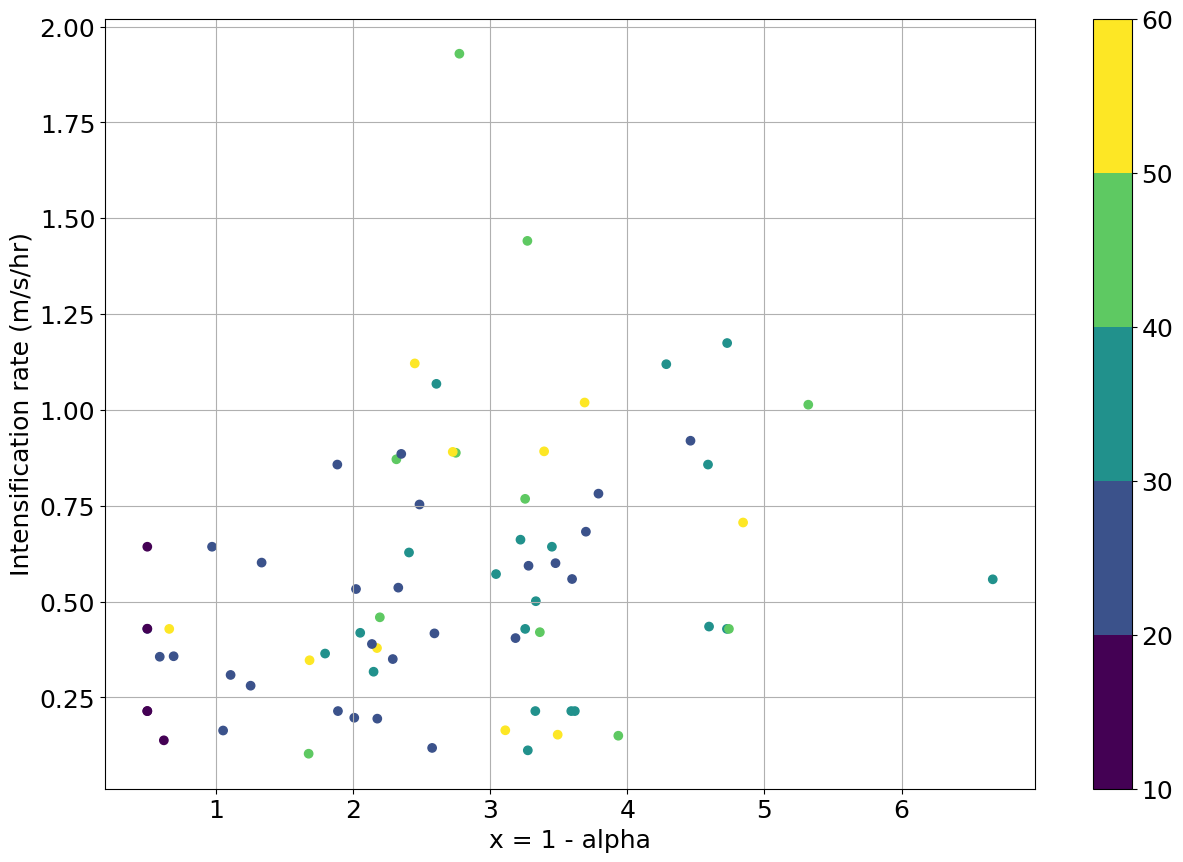

In [13]:
dsg = ds_glob.where((ds_glob.x_var < 0.1) & (ds_glob.Vmax_dot_smth_IBT > 0.1) & (ds_glob.t_since_LMI < 0), drop=True)
plt.scatter(dsg.x_fit, dsg.Vmax_dot_smth_IBT, c=dsg.Vmax_1D, vmin=10, vmax=60, cmap=cm.get_cmap('viridis', 5))
plt.grid();plt.colorbar()
plt.xlabel('x = 1 - alpha');plt.ylabel('Intensification rate (m/s/hr)')

Text(0, 0.5, 't since LMI (hrs)')

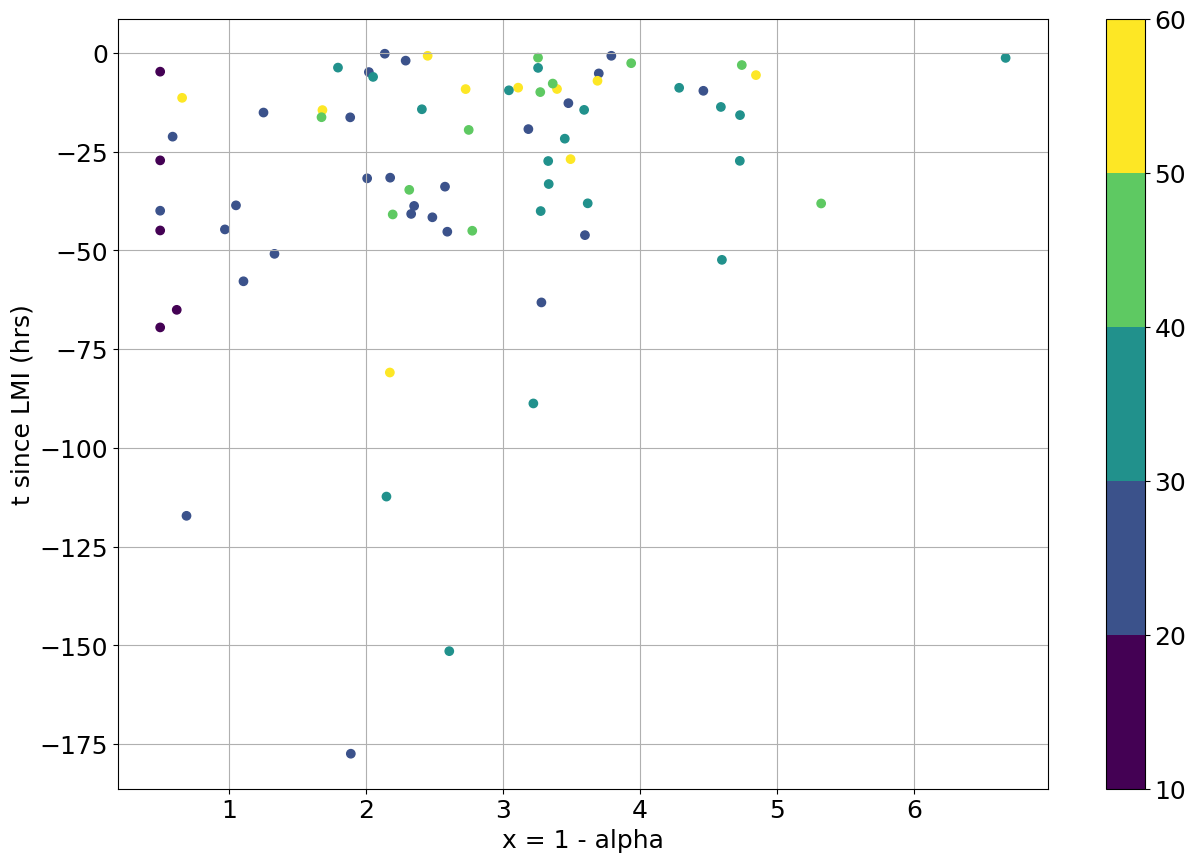

In [14]:
plt.scatter(dsg.x_fit, dsg.t_since_LMI, c=dsg.Vmax_1D, vmin=10, vmax=60, cmap=cm.get_cmap('viridis', 5))
# plt.scatter(dsg.x_fit, dsg.t_since_LMI, c=dsg.t_since_34kts, vmin=24, vmax=150, cmap=cm.get_cmap('gnuplot', 5))
plt.grid();plt.colorbar()
plt.xlabel('x = 1 - alpha');plt.ylabel('t since LMI (hrs)')

Text(0, 0.5, 'LMI / current Vmax')

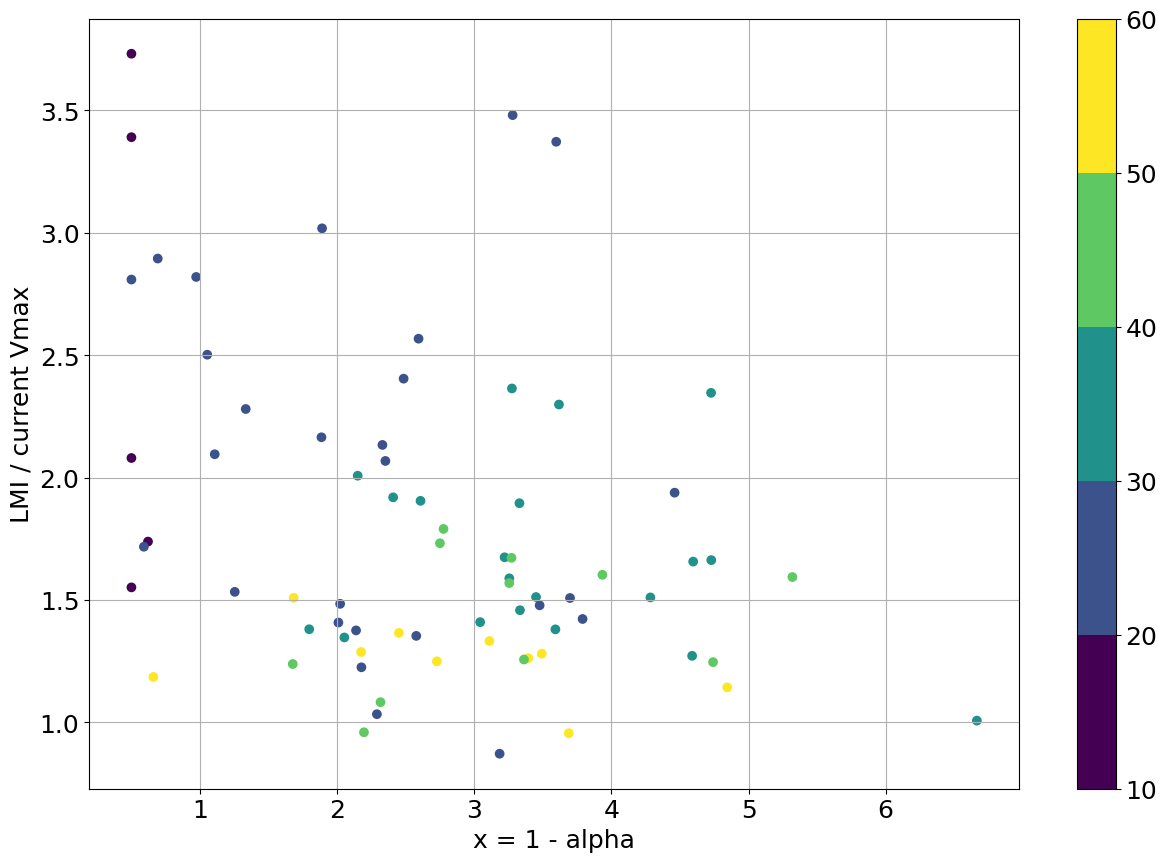

In [16]:
plt.scatter(dsg.x_fit, dsg.LMI_IBT / dsg.Vmax_1D, c=dsg.Vmax_1D, vmin=10, vmax=60, cmap=cm.get_cmap('viridis', 5))
plt.grid();plt.colorbar()
plt.xlabel('x = 1 - alpha');plt.ylabel('LMI / current Vmax')

Text(0, 0.5, 'dRmax/dt')

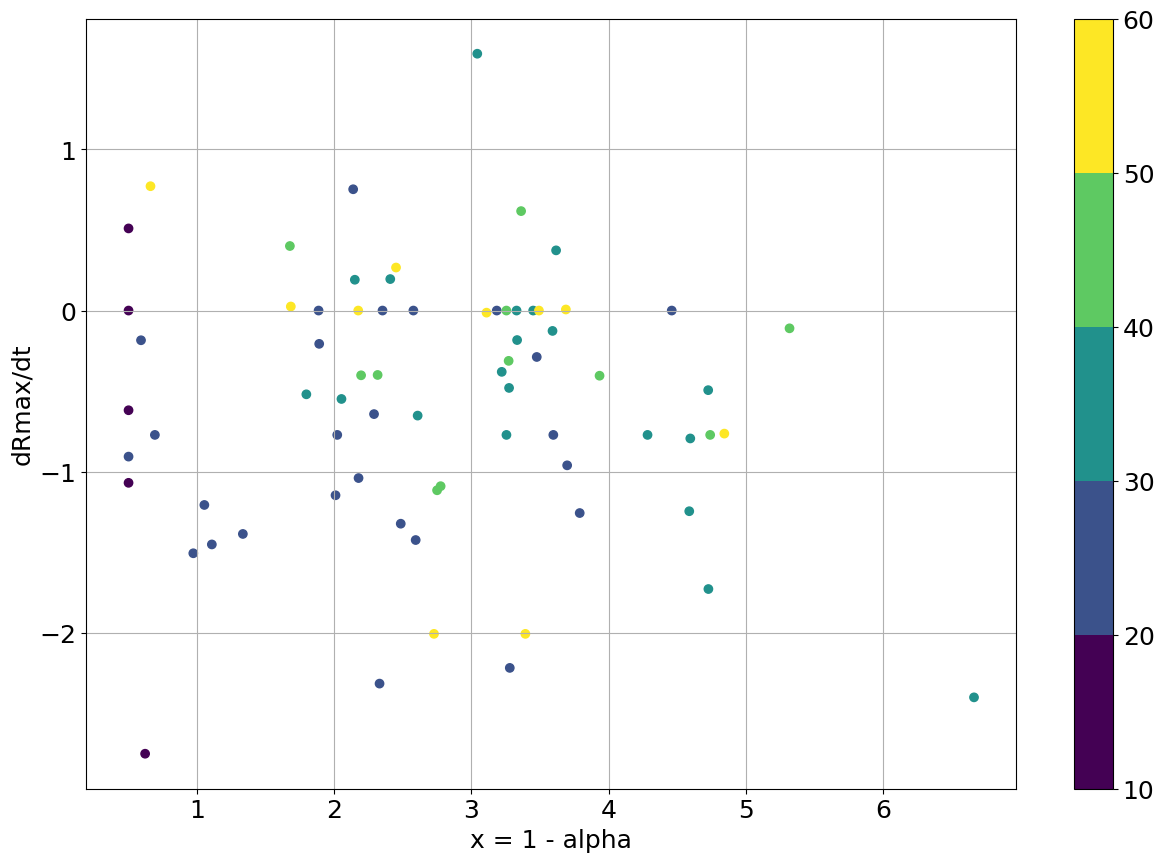

In [19]:
plt.scatter(dsg.x_fit, dsg.Rmax_dot_smth_IBT, c=dsg.Vmax_1D, vmin=10, vmax=60, cmap=cm.get_cmap('viridis', 5))
plt.grid();plt.colorbar()
plt.xlabel('x = 1 - alpha');plt.ylabel('dRmax/dt')

Text(0, 0.5, 'Rmax_LMI / current Rmax')

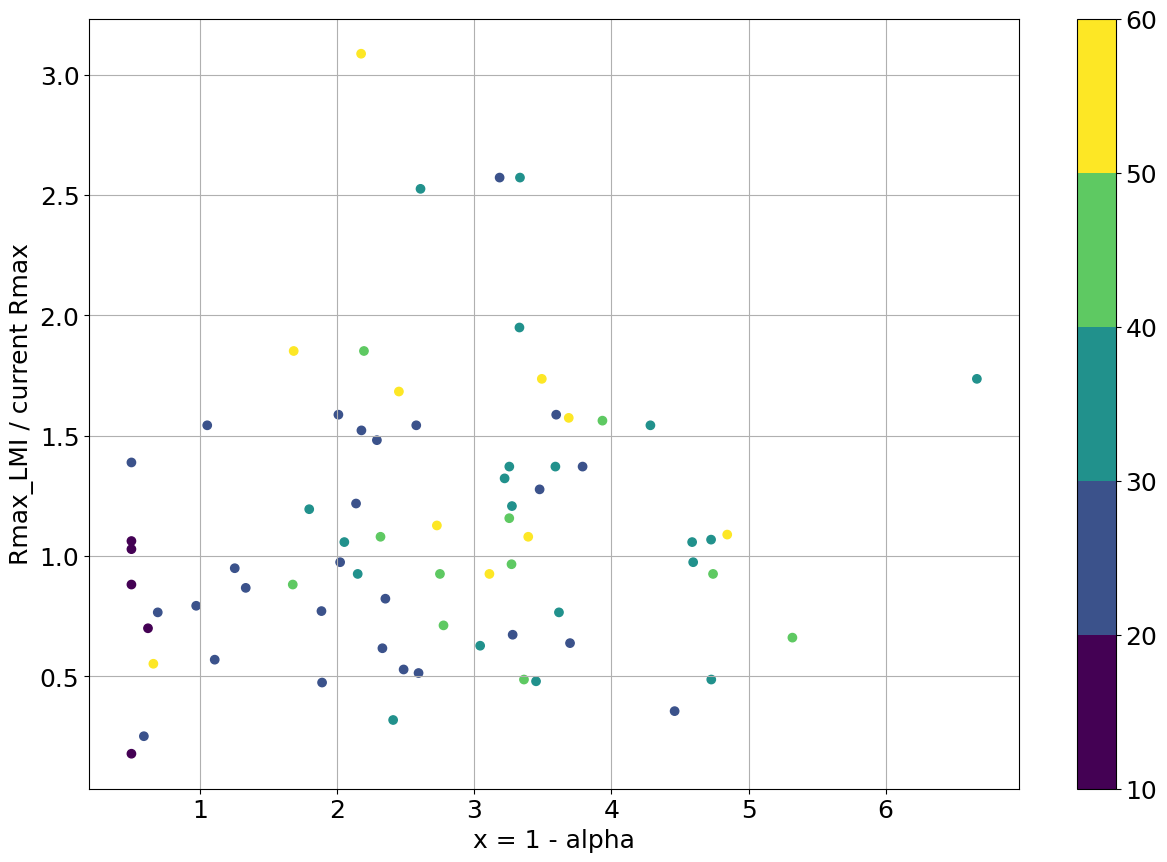

In [22]:
plt.scatter(dsg.x_fit, dsg.Rmax_LMI / dsg.Rmax_1D, c=dsg.Vmax_1D, vmin=10, vmax=60, cmap=cm.get_cmap('viridis', 5))
plt.grid();plt.colorbar()
plt.xlabel('x = 1 - alpha');plt.ylabel('Rmax_LMI / current Rmax')